In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import folium
from sklearn.model_selection import KFold
import xgboost as xgb

sns.set_context('poster')

%matplotlib inline

In [56]:
rs = 42

In [155]:
df = pd.read_csv('transport_data.csv', na_values='-')
df.head()

,longitude,latitude,request_ts,trans_ts,label
0,30.295780,59.932167,1511956827,1511956594,NaN
1,30.219528,59.954617,1511956827,1511956746,NaN
2,30.409101,59.931679,1511956827,1511956747,NaN
3,30.293602,59.938892,1511956827,1511956759,?
4,30.360102,59.931103,1511956827,1511956767,0


In [156]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52000 entries, 3 to 179077
Data columns (total 5 columns):
longitude     52000 non-null float64
latitude      52000 non-null float64
request_ts    52000 non-null int64
trans_ts      52000 non-null int64
label         52000 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 2.4+ MB


In [157]:
df.loc[:, 'request_ts_conv'] = pd.to_datetime(df.request_ts, unit='s')
df.loc[:, 'trans_ts_conv'] = pd.to_datetime(df.trans_ts, unit='s')

In [158]:
# ts extract from request time
df.loc[:, 'req_year'] = df.request_ts_conv.dt.year
df.loc[:, 'req_month'] = df.request_ts_conv.dt.month
df.loc[:, 'req_dayofweek'] = df.request_ts_conv.dt.dayofweek
df.loc[:, 'req_hour'] = df.request_ts_conv.dt.hour
df.loc[:, 'req_minute'] = df.request_ts_conv.dt.minute
df.loc[:, 'req_second'] = df.request_ts_conv.dt.second
# ts extract from trans_time
df.loc[:, 'trans_year'] = df.trans_ts_conv.dt.year
df.loc[:, 'trans_month'] = df.trans_ts_conv.dt.month
df.loc[:, 'trans_dayofweek'] = df.trans_ts_conv.dt.dayofweek
df.loc[:, 'trans_hour'] = df.trans_ts_conv.dt.hour
df.loc[:, 'trans_minute'] = df.trans_ts_conv.dt.minute
df.loc[:, 'trans_second'] = df.trans_ts_conv.dt.second

In [159]:
df = df.drop(['trans_year', 'req_year', 'request_ts_conv', 'trans_ts_conv'], axis=1)

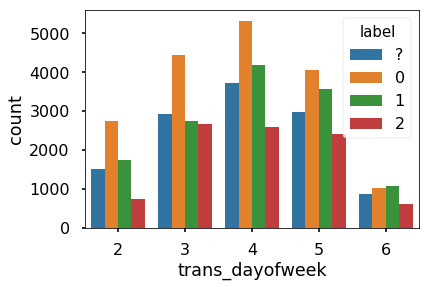

In [143]:
sns.countplot(data=df, x='trans_dayofweek', hue='label');

In [160]:
# feature - diff between trans and request ts
df.loc[:, 'ts_diff'] = (df.trans_ts - df.request_ts).abs()
df.head()

,longitude,latitude,request_ts,trans_ts,label,req_month,req_dayofweek,req_hour,req_minute,req_second,trans_month,trans_dayofweek,trans_hour,trans_minute,trans_second,ts_diff
3,30.293602,59.938892,1511956827,1511956759,?,11,2,12,0,27,11,2,11,59,19,68
4,30.360102,59.931103,1511956827,1511956767,0,11,2,12,0,27,11,2,11,59,27,60
6,30.361664,59.931160,1511956827,1511956774,0,11,2,12,0,27,11,2,11,59,34,53
13,30.374880,59.938213,1511956827,1511956802,?,11,2,12,0,27,11,2,12,0,2,25
16,30.378458,59.940372,1511956827,1511956806,1,11,2,12,0,27,11,2,12,0,6,21


In [11]:
def get_map_for_one_label_day(df, label, month, day, color='red'):
    m = folium.Map(location=[60, 30], zoom_start=10)
    features = folium.FeatureGroup("1")
    cols = ['latitude', 'longitude', 'request_ts_conv']

    df_label = df.loc[(df.label==label) & 
                 (df.request_ts_conv.dt.day == 29) & 
                 (df.request_ts_conv.dt.month == 11), 
                 cols]

    for lat, lng, time in df_label.itertuples(index=False):
        features.add_child(folium.Marker(
            location=[lat, lng],
            popup=str(time),
            icon=folium.Icon(color='red', icon='info-sign')))

    m.add_child(features)
    return m

In [13]:
get_map_for_one_label_day(df, '2', 11, 29)

# Model baseline

## Cross validation setup

In [11]:
df.loc[df.label == '?', 'label'] = np.nan 
df.loc[:, 'label'] = pd.to_numeric(df.label)

In [82]:
kfold = KFold(n_splits = 5, random_state=rs, shuffle=True)
def get_cv_score(ds, target, est_params, metrics='logloss'):
    df.loc[df.label == '?', 'label'] = np.nan
    train_base = df[df.label.notnull()].loc[:, ['longitude', 'latitude']]
    labels_base = pd.to_numeric(df.loc[df.label.notnull()].label)
    X_base = xgb.DMatrix(train_base.values, labels_base.values, feature_names=train_base.columns)
    score = xgb.cv(
        params=est_params, 
        dtrain=X_base,
#         folds=kfold,
        metrics=metrics, 
        num_boost_round=100,
        seed=rs,
        early_stopping_rounds=10
    ).min()
    return score    

In [135]:
df = df.drop(['request_ts_conv', 'trans_ts_conv'], axis=1)

ValueError: labels ['label' 'request_ts_conv' 'trans_ts_conv'] not contained in axis

In [14]:
baseline_params = {
    'max_depth': 5,
    'objective': 'multi:softmax',
    'num_class': 3
}

In [15]:
train_base = df[df.label.notnull()].drop(['label', 'request_ts_conv', 'trans_ts_conv'], axis=1)
labels_base = df.label[df.label.notnull()]
test_base = df[df.label.isnull()].drop(['label', 'request_ts_conv', 'trans_ts_conv'], axis=1)
X_base = xgb.DMatrix(train_base.values, labels_base.values, feature_names=train_base.columns)
base_xgb = xgb.train(baseline_params, X_base)

In [18]:
get_cv_score(df, 'label', baseline_params, 'mlogloss')

test-mlogloss-mean     0.798075
test-mlogloss-std      0.000091
train-mlogloss-mean    0.715031
train-mlogloss-std     0.000433
dtype: float64

In [36]:
base_result = base_xgb.predict(xgb.DMatrix(test_base.values, feature_names=test_base.columns))
list(map(int, base_result))

[1,
 1,
 1,
 2,
 1,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 2,
 2,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [56]:
np.savetxt('data/base.txt', list(map(int, base_result)), fmt='%1i')

# 1NN for fun

In [145]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler
from haversine import haversine

In [224]:
scale = StandardScaler()
# X_nn = df.dropna().loc[df.label!='?'].drop(['request_ts', 'trans_ts', 'label'], axis=1)
X_nn = df.dropna().drop_duplicates(['longitude', 'latitude', 'trans_ts', 'label']).loc[df.label!='?'].loc[:, [
    'longitude', 'latitude',
#     'req_dayofweek', 'req_hour', 'req_minute',
#     'trans_dayofweek', 'trans_hour', 'trans_minute',
]]
y_nn = df.dropna().drop_duplicates(['longitude', 'latitude', 'trans_ts', 'label']).loc[df.label!='?'].label.astype(int)
X_norm_nn = scale.fit_transform(X_nn)

In [1]:
kfold = StratifiedKFold(n_splits=5, random_state=rs)

NameError: name 'StratifiedKFold' is not defined

In [231]:
nn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1, metric=haversine)
cv = cross_val_score(nn, X_norm_nn, y=y_nn, scoring=make_scorer(accuracy_score), cv=kfold)
nn.fit(X_nn, y_nn)

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function haversine at 0x7fe4bf874f28>,
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='uniform')

In [232]:
np.mean(cv)

0.48076328761407838

In [233]:
test_base = df.dropna().loc[df.label == '?'].loc[:, [
    'longitude', 'latitude',
#     'req_dayofweek', 'req_hour', 'req_minute',
#     'trans_dayofweek', 'trans_hour', 'trans_minute',
]]
test_base.info()
X_nn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 3 to 179067
Data columns (total 2 columns):
longitude    12000 non-null float64
latitude     12000 non-null float64
dtypes: float64(2)
memory usage: 281.2 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30333 entries, 4 to 179077
Data columns (total 2 columns):
longitude    30333 non-null float64
latitude     30333 non-null float64
dtypes: float64(2)
memory usage: 710.9 KB


In [2]:
one_nn_pr = nn.predict(test_base)

NameError: name 'nn' is not defined

In [235]:
np.savetxt('data/one_nn.txt', one_nn_pr, fmt='%1i')

In [75]:
# XGBoost on long/lat

In [76]:
baseline_params = {
    'max_depth': 5,
    'objective': 'multi:softmax',
    'num_class': 3
}

In [100]:
df.loc[df.label == '?', 'label'] = np.nan
train_base = df[df.label.notnull()].loc[:, ['longitude', 'latitude']]
test_base = df[df.label.isnull()].loc[:, ['longitude', 'latitude']]
labels_base = pd.to_numeric(df.loc[df.label.notnull()].label)
X_base = xgb.DMatrix(train_base.values, labels_base.values, feature_names=train_base.columns)
base_xgb = xgb.train(baseline_params, X_base)

In [101]:
get_cv_score(df, 'label', baseline_params, 'mlogloss')

test-mlogloss-mean     0.844871
test-mlogloss-std      0.000433
train-mlogloss-mean    0.810362
train-mlogloss-std     0.000375
dtype: float64

In [102]:
base_result = base_xgb.predict(xgb.DMatrix(test_base.values, feature_names=['longitude', 'latitude']))
len(list(map(int, base_result)))

12000

In [103]:
np.savetxt('data/base.txt', list(map(int, base_result)), fmt='%1i')